<a href="https://colab.research.google.com/github/Onethybeing/AGR-Net-Age-Gender-Race-Network-/blob/main/AGR_Net_(Age_Gender_Race_Network).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import kagglehub
jangedoo_utkface_new_path = kagglehub.dataset_download('jangedoo/utkface-new')

print('Data source import complete.')


Data source import complete.


## Multi-Task Learning

Multi-Task Learning (MTL) enables one model to perform many tasks. This innovative approach boosts efficiency and accuracy. It is a core technique in modern artificial intelligence.

So, basically in multi-task learning :
1. **Simultaneous Learning** : MTL models learn multiple tasks at once. They leverage shared internal representations. This improves overall performance.
2. **Improved Generalization** : The goal is to enhance generalization. Tasks can be related or unrelated. This helps the model perform well on unseen data.

### How does MTL learn?
1. **Shared Layers** : Common features are extracted here. These layers form the base.
2. **Task-Specific Layers** : Individual tasks have their own layers. They build on shared features.
3. **Combined Loss Functions** : Losses from all tasks are combined. This guides the learning process.
4. **Backpropagation** : All layers are updated together. This optimizes the entire model.

![image.png](attachment:be4f81be-78fe-4315-a3b1-28b9fdb5ecae.png)

## Import the libraries

In [2]:
#Import necessary Libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, applications, losses, optimizers, metrics
from sklearn.model_selection import train_test_split

In [3]:
#dataset directory
DATASET_DIR = '/kaggle/input/utkface-new/UTKFace'
os.listdir(DATASET_DIR)[0:3]

['26_0_2_20170104023102422.jpg.chip.jpg',
 '22_1_1_20170112233644761.jpg.chip.jpg',
 '21_1_3_20170105003215901.jpg.chip.jpg']

#### From above we find that there is age_gender_race_img_name so, we need to divide them

## Creating the dataset

In [4]:
import os
from PIL import Image

images = []
ages = []
genders = []
races = []

folder = '/kaggle/input/utkface-new/UTKFace'

#converting the name into a datasetlike age_gender_race_image into 4 columns
for filename in os.listdir(folder)[:8000]:
    split = filename.split('_')
    #some images didn't have the race value
    if len(split) >= 4:
        try:
            age = int(split[0])
            gender = int(split[1])
            race = int(split[2])
            img_path = os.path.join(folder, filename)
            image = Image.open(img_path)

            ages.append(age)
            genders.append(gender)
            races.append(race)
            images.append(image)
        except Exception as e:
            print(f"Skipping file {filename}: {e}")
    else:
        print(f"Skipping malformed filename: {filename}")

Skipping malformed filename: 61_1_20170109142408075.jpg.chip.jpg


### Changing images into the images, ages, genders and races and change them to the dataframe to make a dataset and for easier purposes.

In [5]:
#Change the above series into the dataframe
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')
races = pd.Series(list(races), name = 'Races')

#Convert them to the dataset
df = pd.concat([images, ages, genders, races], axis=1)
df.head()

,Images,Ages,Genders,Races
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,26,0,2
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,22,1,1
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,21,1,3
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,28,0,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,17,1,4


#### Map the genders and the races for easier analysis of the dataset

In [6]:
# Map gender and race BEFORE putting into the DataFrame
gender_map = {0: 'm', 1: 'f'}
race_map = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

# Convert genders and races using mapping
genders_mapped = [gender_map[o] for o in genders]
races_mapped = [race_map[o] for o in races]

# Convert to pandas Series
images_series = pd.Series(images, name='img_name')
ages_series = pd.Series(ages, name='age')
genders_series = pd.Series(genders_mapped, name='gender')
races_series = pd.Series(races_mapped, name='race')

# Combine into a DataFrame
df = pd.concat([images_series, ages_series, genders_series, races_series], axis=1)

# Show the DataFrame
df.head()

,img_name,age,gender,race
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,26,m,Asian
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,22,f,Black
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,21,f,Indian
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,28,m,White
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,17,f,Others


#### Add the training and validation in the dataset and add that to know

In [7]:
#divinding into the train and test sets
df['is_train'] = np.random.choice(2, size=len(df), p=[0.2, 0.8])
df.head()

,img_name,age,gender,race,is_train
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,26,m,Asian,1
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,22,f,Black,0
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,21,f,Indian,1
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,28,m,White,1
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,17,f,Others,1


## Visualization of the dataset

<Axes: >

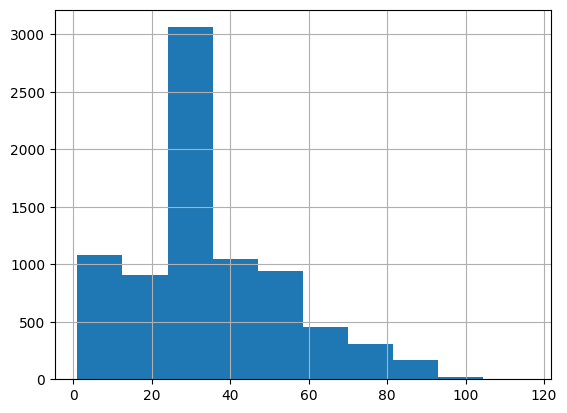

In [8]:
df.age.hist()

<Axes: >

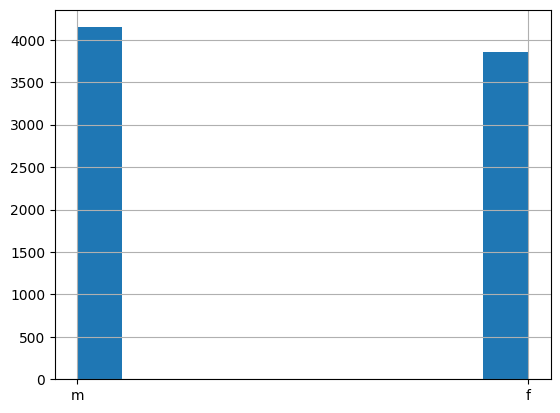

In [9]:
df.gender.hist()

<Axes: >

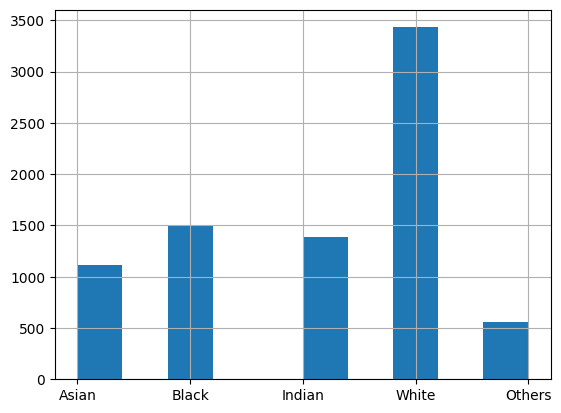

In [10]:
df.race.hist()

#### Seeing the random samples of the dataset

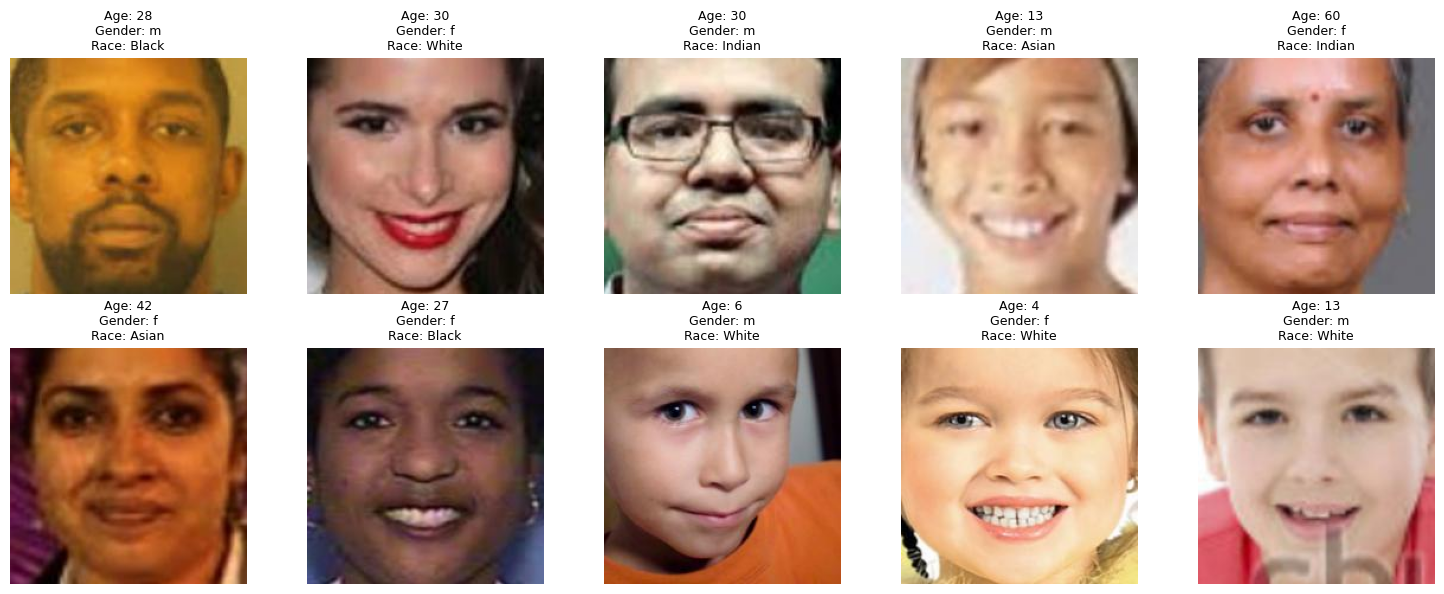

In [11]:
import matplotlib.pyplot as plt

def show_random_samples(df, n=10):
    # Get random samples
    samples = df.sample(n=n, random_state=10)

    # Create subplot grid
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i, (idx, row) in enumerate(samples.iterrows()):
        # Convert PIL image to array and display
        img_array = np.array(row['img_name'])
        axes[i].imshow(img_array)

        # Add title with demographic info
        title = f"Age: {row['age']}\nGender: {row['gender']}\nRace: {row['race']}"
        axes[i].set_title(title, fontsize=9)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Run it
show_random_samples(df)

## Now convert them back to the numerical so that we can use them for model training!!

In [12]:
# Convert categorical labels to numerical for model training
df['gender'] = df['gender'].map({'m': 0, 'f': 1})
df['race'] = df['race'].map({'White': 0, 'Black': 1, 'Asian': 2, 'Indian': 3, 'Others': 4})

# Split data into train and test using the 'is_train' column
train_df = df[df['is_train'] == 1]
test_df = df[df['is_train'] == 0]

print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")

Train samples: 6330, Test samples: 1669


## Creating the Dataset

In [13]:
class PILDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, target_size=(200, 200)):
        self.df = df
        self.batch_size = batch_size
        self.target_size = target_size
        self.indices = np.arange(len(df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        # Shuffle data at the end of each epoch
        np.random.shuffle(self.indices)

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]

        images = []
        ages = []
        genders = []
        races = []

        for _, row in batch_df.iterrows():
            # Directly use the PIL image from DataFrame
            img = row['img_name']

            # Ensure image is RGB (some might be grayscale)
            if img.mode != 'RGB':
                img = img.convert('RGB')

            # Convert to array and resize if needed
            if img.size != self.target_size:
                img = img.resize(self.target_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = img_array / 255.0  # Normalize to [0,1]

            images.append(img_array)
            ages.append(row['age'])
            genders.append(row['gender'])
            races.append(row['race'])

        # One-hot encode race for classification
        races_onehot = tf.keras.utils.to_categorical(races, num_classes=5)

        return np.array(images), {
            'age_output': np.array(ages),
            'gender_output': np.array(genders),
            'race_output': races_onehot
        }

In [14]:
# Create data generators
train_gen = PILDataGenerator(train_df, batch_size=32)
test_gen = PILDataGenerator(test_df, batch_size=32)

## Building the Multi-Task Model

Since, we have 3 different task so regression for age, binary classification for the gender and multi class classification for the races

In [15]:
def build_multi_task_model(input_shape=(200, 200, 3)):
    # Use MobileNetV2 as base for transfer learning
    base_model = applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    base_model.trainable = True  # Fine-tune the base model

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs)

    # Shared Feature Extraction Layers
    shared = layers.Dense(512, activation='relu')(x)
    shared = layers.Dropout(0.5)(shared)

    # Task-Specific Heads
    # Age prediction (regression)
    age_head = layers.Dense(256, activation='relu')(shared)
    age_head = layers.Dropout(0.3)(age_head)
    age_head = layers.Dense(128, activation='relu')(age_head)
    age_output = layers.Dense(1, name='age_output')(age_head)

    # Gender prediction (binary classification)
    gender_head = layers.Dense(128, activation='relu')(shared)
    gender_head = layers.Dropout(0.2)(gender_head)
    gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(gender_head)

    # Race prediction (multi-class classification)
    race_head = layers.Dense(256, activation='relu')(shared)
    race_head = layers.Dropout(0.3)(race_head)
    race_head = layers.Dense(128, activation='relu')(race_head)
    race_output = layers.Dense(5, activation='softmax', name='race_output')(race_head)

    return models.Model(inputs=inputs, outputs=[age_output, gender_output, race_output])

In [16]:
# Build and compile model
model = build_multi_task_model()
model.summary()

/tmp/ipython-input-15-762489061.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 1280)      │  2,257,984 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    655,872 │ mobilenetv2_1.00… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     65,664 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     32,896 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │        129 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │        129 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ race_output (Dense) │ (None, 5)         │        645 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,308,871 (12.62 MB)

 Trainable params: 3,274,759 (12.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

## Defining the Loss Function

In [17]:
# Custom loss weights to balance tasks
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss={
        'age_output': losses.MeanAbsoluteError(),
        'gender_output': losses.BinaryCrossentropy(),
        'race_output': losses.CategoricalCrossentropy()
    },
    loss_weights={
        'age_output': 0.5,  # Less weight for age (regression is harder)
        'gender_output': 1.0,
        'race_output': 1.0
    },
    metrics={
        'age_output': ['mae'],
        'gender_output': ['accuracy'],
        'race_output': ['accuracy']
    }
)

In [18]:
# Add callbacks for better training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )
]

## Training the Model

In [19]:
# Train the model
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


198/198 ━━━━━━━━━━━━━━━━━━━━ 105s 258ms/step - age_output_loss: 19.7097 - age_output_mae: 19.7098 - gender_output_accuracy: 0.6174 - gender_output_loss: 0.7106 - loss: 12.1373 - race_output_accuracy: 0.3580 - race_output_loss: 1.5718 - val_age_output_loss: 10.4860 - val_age_output_mae: 10.5703 - val_gender_output_accuracy: 0.6093 - val_gender_output_loss: 0.6857 - val_loss: 7.4712 - val_race_output_accuracy: 0.4152 - val_race_output_loss: 1.4899 - learning_rate: 1.0000e-04
Epoch 2/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - age_output_loss: 8.0835 - age_output_mae: 8.0834 - gender_output_accuracy: 0.7831 - gender_output_loss: 0.4492 - loss: 5.7453 - race_output_accuracy: 0.5243 - race_output_loss: 1.2545 - val_age_output_loss: 9.9949 - val_age_output_mae: 10.0690 - val_gender_output_accuracy: 0.7945 - val_gender_output_loss: 0.4219 - val_loss: 6.7903 - val_race_output_accuracy: 0.4614 - val_race_output_loss: 1.3442 - learning_rate: 1.0000e-04
Epoch 3/30
198/198 ━━━━━━━━━━━━━━━━━━━

In [20]:
#save the model
model.save('/kaggle/working/multi_task_model.h5')

## Evaluating the Model

In [21]:
results = model.evaluate(test_gen)
print("\nEvaluation Results:")
print(f"Age MAE: {results[4]:.2f} years")
print(f"Gender Accuracy: {results[5]*100:.2f}%")
print(f"Race Accuracy: {results[6]*100:.2f}%")

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - age_output_loss: 5.9430 - age_output_mae: 5.9431 - gender_output_accuracy: 0.9134 - gender_output_loss: 0.3047 - loss: 4.2418 - race_output_accuracy: 0.7633 - race_output_loss: 0.9647

Evaluation Results:
Age MAE: 5.99 years
Gender Accuracy: 89.63%
Race Accuracy: 75.43%


## Predict using the model

In [22]:
def predict_demographics(model, pil_image, target_size=(200, 200)):
    """Predict age, gender and race from PIL image"""
    # Preprocess image
    if pil_image.mode != 'RGB':
        pil_image = pil_image.convert('RGB')
    if pil_image.size != target_size:
        pil_image = pil_image.resize(target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(pil_image)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    age_pred, gender_pred, race_pred = model.predict(img_array)

    # Convert to human-readable format
    gender_map = {0: 'Male', 1: 'Female'}
    race_map = {
        0: 'White',
        1: 'Black',
        2: 'Asian',
        3: 'Indian',
        4: 'Others'
    }

    return {
        'age': age_pred[0][0],
        'gender': gender_map[1 if gender_pred[0][0] > 0.5 else 0],
        'race': race_map[np.argmax(race_pred[0])]
    }

In [23]:
# Test the prediction on a sample from test set
sample = test_df.iloc[0]
result = predict_demographics(model, sample['img_name'])

print("\nSample Prediction:")
print(f"  Image index: {sample.name}")
print(f"  Predicted: Age={result['age']:.1f}, Gender={result['gender']}, Race={result['race']}")
print(f"  Actual:    Age={sample['age']}, Gender={gender_map[sample['gender']]}, Race={race_map[sample['race']]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Sample Prediction:
  Image index: 1
  Predicted: Age=23.4, Gender=Female, Race=Black
  Actual:    Age=22, Gender=f, Race=Black


## Visualizing the Training Parameters

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


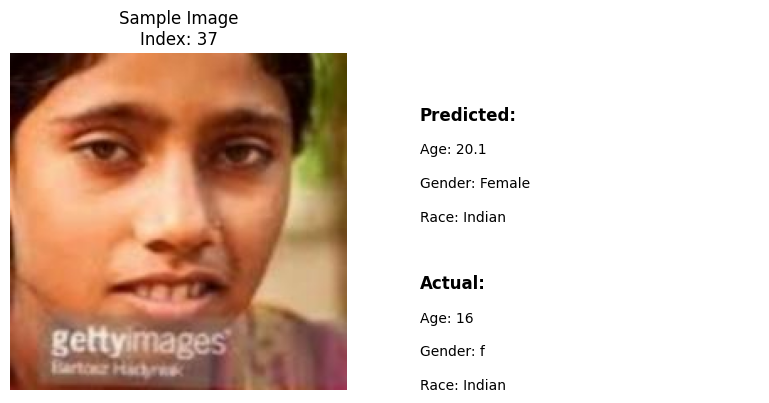

In [24]:
# Enhanced prediction display with image visualization
sample = test_df.iloc[10]
result = predict_demographics(model, sample['img_name'])

# Create figure
plt.figure(figsize=(8, 4))

# Show image
plt.subplot(1, 2, 1)
plt.imshow(np.array(sample['img_name']))
plt.title(f"Sample Image\nIndex: {sample.name}")
plt.axis('off')

# Show prediction vs actual
plt.subplot(1, 2, 2)
plt.text(0.1, 0.8, "Predicted:", fontsize=12, weight='bold')
plt.text(0.1, 0.7, f"Age: {result['age']:.1f}", fontsize=10)
plt.text(0.1, 0.6, f"Gender: {result['gender']}", fontsize=10)
plt.text(0.1, 0.5, f"Race: {result['race']}", fontsize=10)

plt.text(0.1, 0.3, "Actual:", fontsize=12, weight='bold')
plt.text(0.1, 0.2, f"Age: {sample['age']}", fontsize=10)
plt.text(0.1, 0.1, f"Gender: {gender_map[sample['gender']]}", fontsize=10)
plt.text(0.1, 0.0, f"Race: {race_map[sample['race']]}", fontsize=10)

plt.axis('off')
plt.tight_layout()
plt.show()

## Visualizing the training History


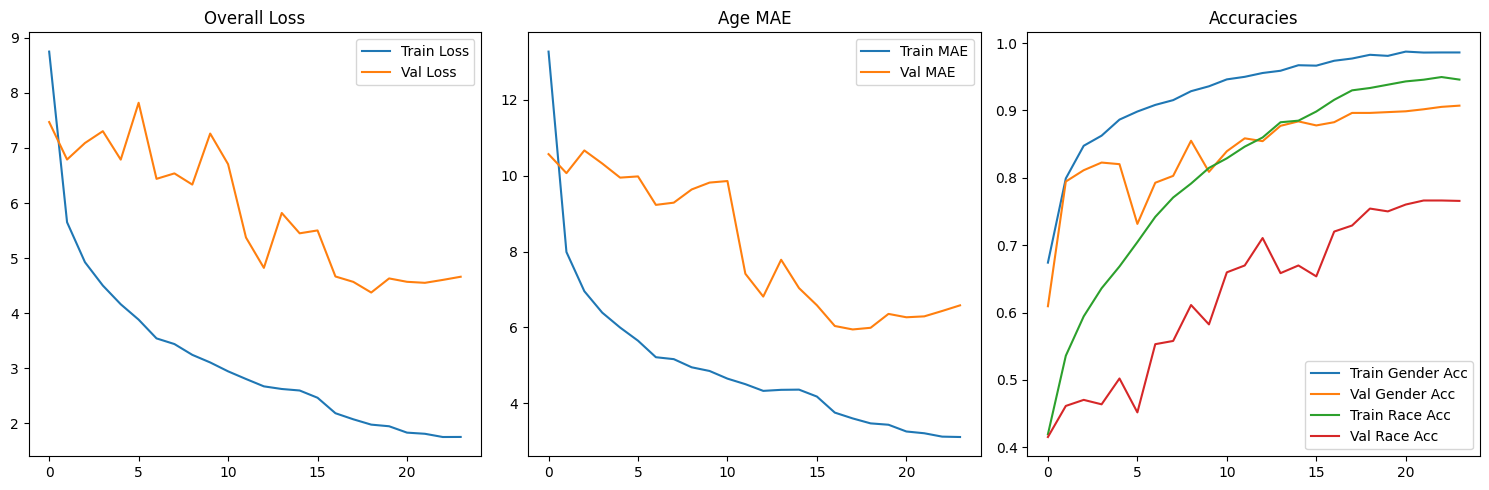

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plot losses
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Overall Loss')
plt.legend()

# Plot age MAE
plt.subplot(1, 3, 2)
plt.plot(history.history['age_output_mae'], label='Train MAE')
plt.plot(history.history['val_age_output_mae'], label='Val MAE')
plt.title('Age MAE')
plt.legend()

# Plot accuracies
plt.subplot(1, 3, 3)
plt.plot(history.history['gender_output_accuracy'], label='Train Gender Acc')
plt.plot(history.history['val_gender_output_accuracy'], label='Val Gender Acc')
plt.plot(history.history['race_output_accuracy'], label='Train Race Acc')
plt.plot(history.history['val_race_output_accuracy'], label='Val Race Acc')
plt.title('Accuracies')
plt.legend()

plt.tight_layout()
plt.show()